In [1]:
import vtk, os
from vtk.util import numpy_support
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

In [2]:
def numpy_from_vtu(file_name, verbose=False):

    # find file name
    for f in os.listdir(file_name + "/4-procs_case/steady-converted-results/"):
        if f.endswith(".vtu"):
            file_name = file_name + "/4-procs_case/steady-converted-results/" + f
    
    # set up reader and read file
    reader = vtk.vtkXMLUnstructuredGridReader()
    reader.SetFileName(file_name)
    reader.Update()

    # Get the 'vtkUnstructuredGrid' object from the reader
    unstructuredGrid = reader.GetOutput()

    # Get point data
    pointData = unstructuredGrid.GetPointData()
    velocityArray = pointData.GetArray("velocity")
    pressureArray = pointData.GetArray("pressure")
    wssArray = pointData.GetArray("vWSS")

    # Convert vtkArray to NumPy array
    velocities = numpy_support.vtk_to_numpy(velocityArray)
    pressures = numpy_support.vtk_to_numpy(pressureArray)
    wsstresses = numpy_support.vtk_to_numpy(wssArray)
    if verbose:
        print(file_name, velocities.shape, pressures.shape, wsstresses.shape)

    # Get the point coordinates
    points = numpy_support.vtk_to_numpy(unstructuredGrid.GetPoints().GetData())

    if verbose:
        print('x', points[:,0].min(), points[:,0].max())
        print('y', points[:,1].min(), points[:,1].max())
        print('z', points[:,2].min(), points[:,2].max())

    # Define the regular grid where you want to interpolate your data
    # The specific values here should be adjusted according to your specific requirements
    grid_x, grid_y, grid_z = np.mgrid[
        points[:,2].min()-10:points[:,2].max()-10:64j,
        points[:,2].min()-10:points[:,2].max()-10:64j,
        points[:,2].min():points[:,2].max():64j
    ]

    # Perform the interpolation
    grid_velocities = griddata(points, velocities, (grid_x, grid_y, grid_z), method='linear', fill_value=0)
    grid_pressures = np.expand_dims(griddata(points, pressures, (grid_x, grid_y, grid_z), method='linear', fill_value=0), axis=-1)
    grid_wsstresses = griddata(points, wsstresses, (grid_x, grid_y, grid_z), method='linear', fill_value=0)
    # The grid_velocities array now contains the interpolated velocity values
    # on the regular grid defined by grid_x, grid_y, and grid_z

    if verbose:
        print(grid_velocities.shape, grid_pressures.shape, grid_wsstresses.shape)

    grid_values = np.concatenate([grid_velocities, grid_pressures, grid_wsstresses], axis=-1)

    return grid_values

In [3]:
import os
exs = [f for f in os.listdir() if 'ex' in f]

In [4]:
# import numpy as np
# grid_values = []
# for file_name in tqdm(exs):
#     if "ex" in file_name:
#         grid_values.append(np.expand_dims(numpy_from_vtu(file_name, verbose=False), axis=0))

In [5]:
from joblib import Parallel, delayed
import numpy as np
from tqdm.notebook import tqdm

def worker(file_name):
    if "ex" in file_name:
        return np.expand_dims(numpy_from_vtu(file_name, verbose=False), axis=0)

grid_values = Parallel(n_jobs=-1)(delayed(worker)(file_name) for file_name in tqdm(exs))

  0%|          | 0/357 [00:00<?, ?it/s]

In [6]:
# from tqdm import tqdm
# grid_values = [np.expand_dims(numpy_from_vtu(file_name, verbose=False), axis=0) for file_name in tqdm(exs)]
# grid_values = np.concatenate(grid_values, axis=0)
# zs = grid_values == 0
# np.save('grid_values.npy', grid_values)

In [7]:
grid_values = np.concatenate(grid_values, axis=0)

In [8]:
from copy import deepcopy

In [9]:
grid_values_temp = deepcopy(grid_values)

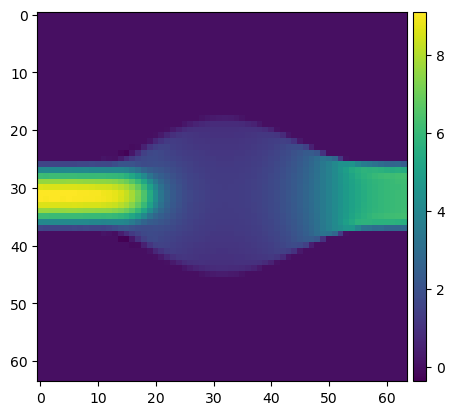

In [10]:
i = 1
vel_comp = 2
fig=plt.figure()
ax = plt.axes()
im = ax.imshow(grid_values_temp[i, :, 30, :, vel_comp])
# plt.colorbar(im,fraction=0.046, pad=0.04)
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax) # Similar to fig.colorbar(im, cax = cax)

In [11]:
values_rearranged = np.transpose(grid_values, axes=[0, 4, 1, 3, 2])
values_rearranged[:, [1, 2], ...] = values_rearranged[:, [2, 1], ...] # reorder velocities v and w

In [12]:
np.save('3daneurysm.npy', values_rearranged)

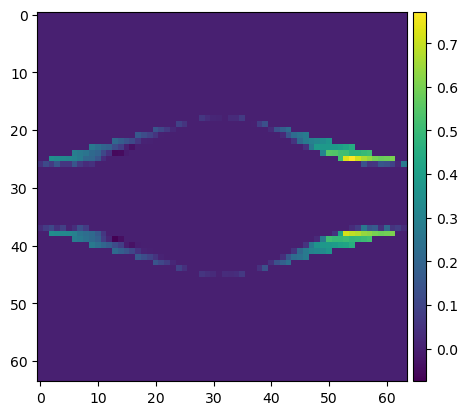

In [17]:
i = 1
vel_comp = 6
fig=plt.figure()
ax = plt.axes()
im = ax.imshow(values_rearranged[i, vel_comp, :, :, 30])
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax)

In [18]:
sstresses = values_rearranged[:, 4:]

In [19]:
sstresses_norm = np.linalg.norm(sstresses, axis=1)

In [20]:
sstresses_norm.shape

(357, 64, 64, 64)

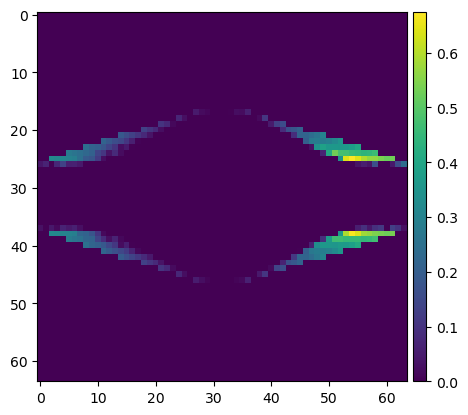

In [26]:
i = 100
vel_comp = 6
fig=plt.figure()
ax = plt.axes()
im = ax.imshow(sstresses_norm[i, :, :, 30])
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax)